# Custom Kernel for latent forces

In [441]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_dataset import JAXP53_Data, load_barenco_data, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

In [442]:
# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al. (plotted points on GP graph)
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

In [443]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

p53_data = JAXP53_Data(replicate=3)
train_t , train_y = flatten_dataset_jax(p53_data)

# Set random key
key = jr.PRNGKey(123)

In [444]:
# TODO: move this to data class itself (?)

num_genes = p53_data.num_outputs
# (num_genes, dimension, num_timepoints)
gene_data = jnp.array([p53_data[i] for i in range(num_genes)])

time_points = gene_data[0,0,:]
time_points_repeated = jnp.repeat(time_points, gene_data.shape[0])
gene_indices = jnp.repeat(jnp.arange(gene_data.shape[0]), len(time_points))


# Shape (t x j) x 3 where t is timepoints and j is genes
training_times = jnp.stack((time_points_repeated, gene_indices, jnp.ones(num_genes * len(time_points), dtype=int)), axis=-1)


# Shape (t x j) x 1 where t is timepoints and j is genes
gene_expressions = gene_data[:,1,:].flatten().reshape(-1,1)

dataset_train = gpx.Dataset(training_times, gene_expressions)

In [445]:
# Generate test points (t, i, 1):

def gen_test_times(t=100):
    """
    Generate testing times for the model of shape (N, 3) where N is the number of testing times. Default is N = 100
    """
    times = jnp.linspace(0, 12, t)
    # Gene indices shouldn't matter
    gene_indices = jnp.repeat(-1, t)
    testing_times = jnp.stack((times, gene_indices, jnp.repeat(0,t)), axis=-1)
    return testing_times

gen_test_times().shape

(100, 3)

In [446]:
testing_times = gen_test_times()

train_row = dataset_train.X[20]
test_row = testing_times[20]

In [447]:
"""
def __call__(self, X: 'Float[Array, "1 D"]', Xp: 'Float[Array, "1 D"]') -> 'Float[Array, "1"]':
    z = jnp.array(X[2], dtype=int)
    zp = jnp.array(Xp[2], dtype=int)

    # Switches for different kernel functions
    kxx_switch = (1 - z) * (1 - zp)
    kff_switch = z * zp
    kxf_switch = (1 - z) * zp
    kxf_t_switch = z * (1 - zp)

    # Compute the kernel value based on the switches
    result = (kxx_switch * self.kxx(X, Xp) +
                kff_switch * self.kff(X, Xp) +
                kxf_switch * self.kxf(X, Xp) +
                kxf_t_switch * self.kxf_transpose(X, Xp))
    return result
        
"""

'\ndef __call__(self, X: \'Float[Array, "1 D"]\', Xp: \'Float[Array, "1 D"]\') -> \'Float[Array, "1"]\':\n    z = jnp.array(X[2], dtype=int)\n    zp = jnp.array(Xp[2], dtype=int)\n\n    # Switches for different kernel functions\n    kxx_switch = (1 - z) * (1 - zp)\n    kff_switch = z * zp\n    kxf_switch = (1 - z) * zp\n    kxf_t_switch = z * (1 - zp)\n\n    # Compute the kernel value based on the switches\n    result = (kxx_switch * self.kxx(X, Xp) +\n                kff_switch * self.kff(X, Xp) +\n                kxf_switch * self.kxf(X, Xp) +\n                kxf_t_switch * self.kxf_transpose(X, Xp))\n    return result\n        \n'

In [468]:
# Kernel is element wise (i.e. rows)
def kernel_switch_testing(X, Y):
    """
    Testing switch implementation for kernel switching.

    Parameters:
    X: Row of input with shape (1, 3)
    Y: Row of input withshape (1, 3)

    Returns:
        Integer
    """
 
    f1 = jnp.array(X[2], dtype=int)
    f2 = jnp.array(Y[2], dtype=int)
    

    kxx_switch = f1 * f2
    kff_switch = (1 - f1) * (1 - f2)
    kxf_switch = f1 * (1 - f2)
    kxf_t_switch = (1 - f1) * f2

    print(f'kxx: {kxx_switch}')
    print(f'kff: {kff_switch}')
    print(f'kxf: {kxf_switch}')
    print(f'kfx: {kxf_t_switch}')

    return None

In [449]:
# GPJAX KERNEL IS ELEMENT WISE

In [450]:
pos_constraint = tfb.Softplus()

init_s = pos_constraint.inverse(1.0)
init_s

Array(0.54132485, dtype=float32)

In [451]:
@dataclass
class test_kernel(gpx.kernels.AbstractKernel):


    def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:

        print('called')


        h = self.h()
        print(h)

        return None
    
    def h(self):
        print('H called')
        return 1
    
test_ker = test_kernel()
test_ker(2,2)

called
H called
1


In [527]:
@dataclass
class p53_kxx(gpx.kernels.AbstractKernel):
    r"Covariance function of gene expressions j and k at time t and t'"

    # TODO: review inverse initialisation method - check if init as list or single param
    pos_constraint: Callable = tfb.Softplus()
    initial_s: Float[Array, " O"] = static_field(pos_constraint.inverse(1.0))
    initial_d: Float[Array, " O"] = static_field(pos_constraint.inverse(0.4))
    
    # Use dummy variables before trying inverse method
    initial_s_test: Float[Array, " O"] = static_field(jnp.array([1.0]))
    initial_d_test: Float[Array, " O"] = static_field(jnp.array([1.0]))

    # Define sensitivities for both genes
    s_j: Float[Array, " O"] = param_field(initial_s_test, bijector=pos_constraint)
    s_k: Float[Array, " O"] = param_field(initial_s_test, bijector=pos_constraint)

    # Define decay rates for both genes
    d_j: Float[Array, " O"] = param_field(initial_d_test, bijector=pos_constraint)
    d_k: Float[Array, " O"] = param_field(initial_d_test, bijector=pos_constraint)

    # Use measured sensiivities and decays at first
    true_s: Float[Array, "1 5"] = static_field(jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680]))
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573]))

    # Use dummy lengthscale at first
    l: Float[Array, " O"] = static_field(jnp.array([2.5]))
    
    
    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        """

        # Error trap (JAX friendly)
        def check_validity(condition):
            if condition:
                raise ValueError("t or t' cannot be testing points (z=0)")

        condition = jnp.logical_or(t[2] == 0, t_prime[2] == 0)
        jax.debug.callback(check_validity, condition)
        
        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        """
        print('kxx has been called')
        print(self.true_s)
        print(self.true_d)
        print(t.shape)
        print(t_prime.shape)

        print(f'lengthscale {self.l}, {type(self.l)}')
        """

        # NOTE: using index yields same results
        t = self.slice_input(t)
        t_prime = self.slice_input(t_prime)


        """
        print('Inputs have been sliced')
        print(t, t.shape)
        print(t, t_prime.shape)
        """

        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k,j, t_prime, t) + self.h(j,k, t, t_prime)
        

        kxx = mult * second_term

        """
        print(second_term.shape)
        print(f'mult {mult}, shape: {mult.shape}')
        print(f'second term {second_term}, shape: {second_term.shape}')

        print(f'kxx shape {kxx.shape}')
        """

        return kxx.squeeze()
        
    
    def h(self,j: Int[Array, " O"],k: Int[Array, " O"],t1: Int[Array, " O"],t2: Int[Array, " O"]) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        t_dist = jnp.abs(t1-t2)

        multiplier = jnp.exp(self.gamma(k)**2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k]*t_dist)
        first_erf_terms = jax.scipy.special.erf((t_dist / self.l) - self.gamma(k)) + jax.scipy.special.erf(self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k]*t2 + self.true_d[j]*t1))
        second_erf_terms = jax.scipy.special.erf((t2 / self.l) - self.gamma(k)) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (jnp.multiply(first_multiplier, first_erf_terms) - jnp.multiply(second_multiplier, second_erf_terms))

        return result
    
    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) /2


In [491]:
@dataclass
class p53_kxf(gpx.kernels.AbstractKernel):
    r"Cross-covariance between gene expression j at time t and f at time t'"

    # TODO: look at initialisation methods and sharing of parameters between covariances

    # Use measured sensiivities and decays at first
    true_s: Float[Array, "1 5"] = static_field(jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680]))
    true_d: Float[Array, "1 5"] = static_field(jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573]))

    # Use dummy lengthscale at first
    l: Float[Array, " O"] = static_field(jnp.array([2.5]))

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:
        
        # Error trap (JAX friendly)
        def check_val_test(condition):
            if condition:
                raise ValueError("t and t' cannot both be testing points (z=0)")
            
        def check_val_train(condition):
            if condition:
                raise ValueError("t and t' cannot both be training points (z=1)")
            
        cond_test = jnp.logical_and(t[2] == 0, t_prime[2] == 0)
        cond_train = jnp.logical_and(t[2] == 1, t_prime[2] == 1)

        jax.debug.callback(check_val_test, cond_test)
        jax.debug.callback(check_val_train, cond_train)

        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)
    
        j = gene_xpr[1]

        print(f'Latent force {latent_force}')
        print(f'Gene expression {gene_xpr}')    
        

        return 0


In [454]:
@dataclass
class p53_combined_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = 'p53 Cov'

    # Define external kernels
    kernel_xx: gpx.kernels.AbstractKernel = field(default_factory=lambda: p53_kxx(active_dims=[0]))

    kernel_xf: int = 2
    kernel_ff: int = 3

    def __call__(self, t: Int[Array, "1 3"], t_prime: Int[Array, "1 3"]) -> ScalarFloat:

        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        #kernel_to_use = kxx_switch * self.kernel_xx(t, t_prime) + kff_switch * self.kernel_ff(t, t_prime) + kxf_switch * self.kernel_xf(t, t_prime) + kxf_t_switch * self.kernel_xf(t_prime, t)

        # .squeeze() ?
        #return kernel_to_use
        print('hi')
        #kernel_kxx = jnp.array(self.kernel_xx(t, t_prime))
        kernel_kxx = self.kernel_xx(t, t_prime)
        print(kernel_kxx)
  

        return 0

In [455]:
## Look at shared training parameters (??)

In [462]:
p53_ker = p53_combined_kernel()
p53_ker(train_row,train_row)

hi
-0.032596097197167516


0

In [488]:
train_row

Array([8., 2., 1.], dtype=float64)

In [494]:
k_xf = p53_kxf(active_dims=[0])
k_xf(dataset_train.X[20],test_row)

Latent force [ 2.42424242 -1.          0.        ]
Gene expression [8. 2. 1.]


0

In [458]:
train_row

Array([8., 2., 1.], dtype=float64)

In [528]:
kxx_ker = p53_kxx(active_dims=[0])
t1 = dataset_train.X
t1.shape

(35, 3)

In [529]:
kxx_ker(train_row,train_row)

Inputs have been sliced
[8.] (1,)
[8.] (1,)
8.0 ()
8.0 ()


Array(-0.0325961, dtype=float64)

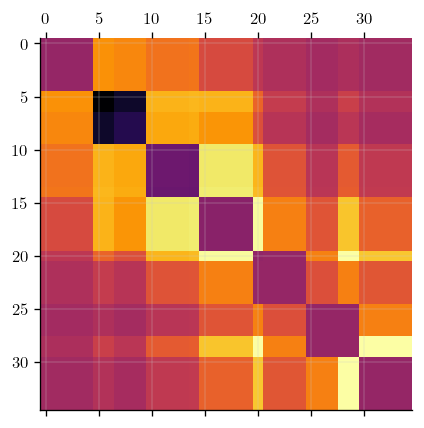

In [503]:
plt.matshow(kxx_ker.gram(t1).to_dense())
plt.show()

(35, 3)

In [ ]:
# HOW TO PLOT KERNEL AND CHECK IT LOOKS OK?

In [344]:
n = 100
noise = 0.3
x_gpr = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f_gpr = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)

kernel_gpr = gpx.kernels.RBF(active_dims=[0])

In [341]:
x_gpr_new = jnp.stack((x_gpr.reshape(-1,), jnp.repeat(0, 100)), axis=-1)
x_gpr_new



Array([[-0.15513296,  0.        ],
       [ 0.20999486,  0.        ],
       [ 2.70871393,  0.        ],
       [-0.24233199,  0.        ],
       [ 0.62798972,  0.        ],
       [-1.04605396,  0.        ],
       [-0.29715902,  0.        ],
       [ 0.89566759,  0.        ],
       [-2.13326535,  0.        ],
       [-1.59715151,  0.        ],
       [ 0.02428609,  0.        ],
       [ 1.92848615,  0.        ],
       [ 1.6970173 ,  0.        ],
       [-0.6035951 ,  0.        ],
       [ 0.26813325,  0.        ],
       [-0.25503812,  0.        ],
       [ 2.57459184,  0.        ],
       [-0.99307462,  0.        ],
       [ 2.10230002,  0.        ],
       [-1.58137953,  0.        ],
       [ 1.57460624,  0.        ],
       [ 0.12240851,  0.        ],
       [-0.70544628,  0.        ],
       [-1.86591987,  0.        ],
       [-1.53468077,  0.        ],
       [ 2.15706123,  0.        ],
       [-1.70874549,  0.        ],
       [-2.28593996,  0.        ],
       [-0.66266154,

In [346]:
kernel_gpr(x_gpr_new,x_gpr_new)

Array(1., dtype=float64)

In [384]:
testing_times.shape

(100, 3)

In [472]:
kernel_switch_testing(train_row, test_row)

kxx: 0
kff: 0
kxf: 1
kfx: 0


In [ ]:
plt.matshow(kxx_ker.gram)